In [146]:
# imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [147]:
# read in the data into a pandas dataframe for visualization
data = pd.read_csv('evs.csv')
data.head()

,id,drive,acceleration,topspeed,electricrange,totalpower,batterycapacity,chargespeed
0,1647,Rear,7.8,185,390,168,77.4,49
1,1252,Rear,5.7,190,470,250,83.9,54
2,1534,Rear,7.9,160,450,150,82.0,55
3,1178,Rear,8.9,160,275,110,55.0,38
4,1279,Rear,8.7,160,330,132,62.0,53


In [148]:
# one hot encode the categorical columns
onehot_data = pd.get_dummies(data, drop_first=True, dtype = int)
onehot_data.head()

,id,acceleration,topspeed,electricrange,totalpower,batterycapacity,chargespeed,drive_Rear
0,1647,7.8,185,390,168,77.4,49,1
1,1252,5.7,190,470,250,83.9,54,1
2,1534,7.9,160,450,150,82.0,55,1
3,1178,8.9,160,275,110,55.0,38,1
4,1279,8.7,160,330,132,62.0,53,1


In [149]:
# convert data to a numpy array
numpy_data = onehot_data.to_numpy()
numpy_data.shape

(119, 8)

In [150]:
# separate X and y features
X = numpy_data[:, 1:-1]
y = numpy_data[:, -1]

In [151]:
# min-max scale the data
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X

array([[  7.8, 185. , 390. , 168. ,  77.4,  49. ],
       [  5.7, 190. , 470. , 250. ,  83.9,  54. ],
       [  7.9, 160. , 450. , 150. ,  82. ,  55. ],
       [  8.9, 160. , 275. , 110. ,  55. ,  38. ],
       [  8.7, 160. , 330. , 132. ,  62. ,  53. ],
       [  8.6, 160. , 420. , 150. ,  82. ,  51. ],
       [  9. , 135. , 135. ,  70. ,  23.8,  59. ],
       [  6.7, 180. , 350. , 200. ,  66. ,  34. ],
       [  7.3, 185. , 390. , 168. ,  77.4,  49. ],
       [ 11.7, 135. , 200. , 100. ,  50. ,  28. ],
       [ 11.7, 135. , 200. , 100. ,  50. ,  28. ],
       [  8.5, 160. , 405. , 150. ,  82. ,  49. ],
       [ 12.1, 130. , 180. , 100. ,  50. ,  25. ],
       [ 10.9, 160. , 285. , 109. ,  55. ,  34. ],
       [  6.8, 180. , 385. , 210. ,  80. ,  49. ],
       [  9. , 160. , 295. , 125. ,  55. ,  35. ],
       [  7.8, 167. , 380. , 150. ,  68. ,  55. ],
       [  8.7, 150. , 260. , 100. ,  50. ,  36. ],
       [ 12.1, 130. , 180. , 100. ,  50. ,  25. ],
       [  7.9, 200. , 335. , 13

In [152]:
# add bias term
X_bias = np.hstack([np.ones((X_scale.shape[0], 1)), X_scale])
X_bias.shape

(119, 7)

In [153]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83, 7), (36, 7), (83,), (36,))

In [154]:
# define functions to be used in the MLP process
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_loss(y_true, y_pred):
    n = len(y_true)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    y_true = y_true.reshape(-1, 1)
    loss = (1/n) * np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
    return loss

def dL_dw1(X, y_true, y_pred, w2, z1):
    n = len(y_true)
    error = y_pred - y_true.reshape(-1, 1)
    relu_der = (z1 > 0).astype(float)
    dL_dW1 = (1/n) * (X.T @ ((error @ w2.T) * relu_der))
    return dL_dW1

def dL_dw2(y_true, y_pred, h):
    n = len(y_true)
    error = y_pred - y_true.reshape(-1, 1)
    dL_dw2 = (1/n) * (h.T @ error)
    return dL_dw2

In [170]:
# initialize weights
np.random.seed(42)
w1 = np.random.randn(X_train.shape[1], 4) * 0.01
w2 = np.random.randn(4, 1) * 0.01
w1.shape, w2.shape

((7, 4), (4, 1))

In [171]:
# initialize hyper parameters
epochs = 500
lr = 0.2

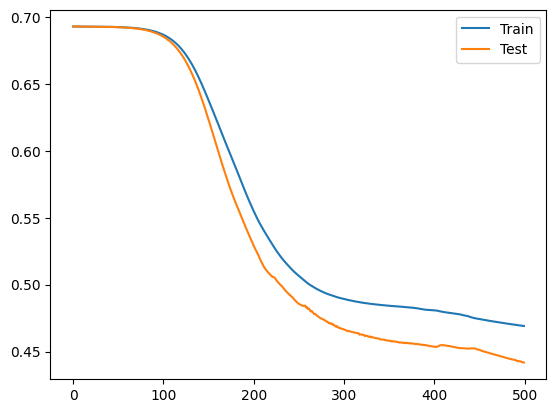

In [172]:
# training loop
train_loss_list = []
test_loss_list = []
for epoch in range(epochs):
    # forward pass (training)
    z1 = X_train @ w1
    h = relu(z1)
    z2 = h @ w2
    y_pred = sigmoid(z2)
    
    # forward pass (test)
    z1_test = X_test @ w1
    h_test = relu(z1_test)
    z2_test = h_test @ w2
    y_pred_test = sigmoid(z2_test)
    
    # compute loss
    train_loss = log_loss(y_train, y_pred)
    test_loss = log_loss(y_test, y_pred_test)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    # compute gradients
    grad_w2 = dL_dw2(y_train, y_pred, h)
    grad_w1 = dL_dw1(X_train, y_train, y_pred, w2, z1)
    
    # update parameters
    w2 = w2 - lr * grad_w2
    w1 = w1 - lr * grad_w1

plt.plot(train_loss_list, label='Train')
plt.plot(test_loss_list, label='Test')
plt.legend()
plt.show()

In [173]:
print("Final w1:\n", w1)
print("Final w2:\n", w2)

z1_test = X_test @ w1
h_test = relu(z1_test)
z2_test = h_test @ w2
y_pred_test = sigmoid(z2_test)
predictions = (y_pred_test > 0.5).astype(int)
accuracy = np.mean(predictions == y_test.reshape(-1, 1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Final w1:
 [[ 2.98797221e-01 -1.38264301e-03  6.75623746e-01  1.77215461e-03]
 [ 6.66386267e-01 -2.34136957e-03  1.47586668e+00  2.22439516e-03]
 [-5.72750784e-01  5.42560044e-03 -1.27193184e+00 -5.92761229e-03]
 [-4.27952935e-01 -1.91328024e-02 -9.79733176e-01 -7.15632361e-03]
 [-2.58193305e-01  3.14247333e-03 -5.33921041e-01 -1.64445242e-02]
 [-4.05648789e-02 -2.25776300e-03 -1.06623903e-01 -1.70198849e-02]
 [-1.44125414e-02  1.10922590e-03 -5.75436249e-02  3.06654248e-04]]
Final w2:
 [[-1.05444343]
 [-0.00291694]
 [-2.34691634]
 [ 0.01519083]]
Test Accuracy: 66.67%
